# Imports

In [1]:
import urllib.request, json
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import math
import datetime
import pickle
import math
import collections
from tqdm import tqdm

# Queries

## Get the sites

### Get a list of allUK sites

Download information about all sites in the UK.

In [2]:
url_text = "https://webtris.highwaysengland.co.uk/api/v1/sites"
with urllib.request.urlopen(url_text) as url:
    data = json.loads(url.read().decode())
    
sites = data['sites']
sites[0]

{'Id': '1',
 'Name': 'MIDAS site at M4/2295A2 priority 1 on link 105009001; GPS Ref: 502816;178156; Westbound',
 'Description': 'M4/2295A2',
 'Longitude': -0.520379557723297,
 'Latitude': 51.4930115367112,
 'Status': 'Inactive'}

### Filter onto Areas

Next we are going to filter onto our train and test areas via coordinates.

The train area is Birmingham and the test area is Cambridge.

In [3]:
# Specify dates
start_date='01062021'
end_date = '15062022'

# Specify the train area we are looking at
max_lat = 52.50
max_long = -1.67
min_lat = 52.42
min_long = -1.75

quality_threshold = 40

def get_quality_area(sites,
                     max_lat,
                     max_long,
                     min_lat,
                     min_long,
                     start_date='01062021',
                     end_date = '15062022',
                     quality_threshold = 40):
    
    # Convert sites query into df and filter onto our area
    sites_df = pd.DataFrame(data = sites)
    area_sites_df = sites_df.loc[(min_long < sites_df.Longitude) & (sites_df.Longitude < max_long)
                                & (min_lat < sites_df.Latitude) & (sites_df.Latitude < max_lat)]
    area_sites_df = area_sites_df.reset_index(drop=True)
    area_ids = list(area_sites_df.Id)
    
    # Next filter onto sites with good quality data:
    quality_responces = []
    for site_id in tqdm(area_ids):
        url_text = f"https://webtris.highwaysengland.co.uk/api/v1/quality/overall?sites={site_id}&start_date={start_date}&end_date={end_date}"
        with urllib.request.urlopen(url_text) as url:
            responce = json.loads(url.read().decode())
        quality_responces.append(responce)
        
    # We only want sites with quality greater than threshold
    good_quality_ids = []
    for responce in quality_responces:
        if responce['data_quality'] >= quality_threshold:
            good_quality_ids.append(responce['sites'])

    quality_area_sites_df = area_sites_df.loc[area_sites_df.Id.isin(good_quality_ids)]
    quality_area_sites_df = quality_area_sites_df.reset_index(drop=True)
    
    return quality_area_sites_df

In [4]:
train_sites_df = get_quality_area(sites,
                     max_lat,
                     max_long,
                     min_lat,
                     min_long,
                     start_date='01062021',
                     end_date = '15062022',
                     quality_threshold = 40)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 331/331 [00:25<00:00, 13.00it/s]


In [14]:
train_sites_df.head()

,Id,Name,Description,Longitude,Latitude,Status
0,175,MIDAS site at M42/6482L priority 1 on link 126...,M42/6482L,-1.716752,52.497242,Active
1,561,MIDAS site at M42/6473B priority 1 on link 199...,M42/6473B,-1.713067,52.490841,Active
2,1102,MIDAS site at M42/6468A priority 1 on link 126...,M42/6468A,-1.711725,52.484392,Active
3,1608,MIDAS site at M6/5711L priority 1 on link 1110...,M6/5711L,-1.715598,52.479798,Active
4,1747,MIDAS site at M6/5732B priority 1 on link 1990...,M6/5732B,-1.734829,52.494379,Active


For the test region we will look at cambrideshire

In [11]:
# Specify the test area we are looking at
max_lat = 52.2483066752076
max_long = 0.165885814809103  
min_lat = 52.2073405057841
min_long = 0.019739836803521 

test_sites_df = get_quality_area(sites,
                     max_lat,
                     max_long,
                     min_lat,
                     min_long,
                     start_date='01062021',
                     end_date = '15062022',
                     quality_threshold = 40)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 94/94 [00:07<00:00, 12.54it/s]


In [15]:
test_sites_df.head()

,Id,Name,Description,Longitude,Latitude,Status
0,65,MIDAS site at M11/6904A priority 1 on link 200...,M11/6904A,0.071998,52.229434,Active
1,2166,MIDAS site at M11/6885J priority 1 on link 199...,M11/6885J,0.077154,52.213140,Active
2,3092,MIDAS site at M11/6886A priority 1 on link 199...,M11/6886A,0.078060,52.214050,Active
3,4178,MIDAS site at M11/6886B priority 1 on link 199...,M11/6886B,0.078263,52.214011,Active
4,7846,TMU Site 6818/2 on link A428 eastbound between...,6818/2,0.029791,52.216833,Active


### Export the site dataframes

In [16]:
train_sites_df.to_feather('train_sites_df')
test_sites_df.to_feather('test_sites_df')

### Export the sites to a GDF

In [2]:
train_sites_df = pd.read_feather('train_sites_df')
test_sites_df = pd.read_feather('test_sites_df')

In [9]:
import geopandas

train_sites_gdf = geopandas.GeoDataFrame(
    train_sites_df, geometry=geopandas.points_from_xy(train_sites_df.Longitude, train_sites_df.Latitude))

test_sites_df = geopandas.GeoDataFrame(
    test_sites_df, geometry=geopandas.points_from_xy(test_sites_df.Longitude, test_sites_df.Latitude))


train_sites_gdf.to_file("train_sites_gdf.geojson", driver='GeoJSON')
test_sites_df.to_file("test_sites_df.geojson", driver='GeoJSON')

ERROR 1: PROJ: proj_create_from_database: Open of /vol/bitbucket/jrb21/anaconda3/envs/sklearn-env/share/proj failed


In [10]:
train_sites_gdf

,Id,Name,Description,Longitude,Latitude,Status,geometry
0,175,MIDAS site at M42/6482L priority 1 on link 126...,M42/6482L,-1.716752,52.497242,Active,POINT (-1.71675 52.49724)
1,561,MIDAS site at M42/6473B priority 1 on link 199...,M42/6473B,-1.713067,52.490841,Active,POINT (-1.71307 52.49084)
2,1102,MIDAS site at M42/6468A priority 1 on link 126...,M42/6468A,-1.711725,52.484392,Active,POINT (-1.71173 52.48439)
3,1608,MIDAS site at M6/5711L priority 1 on link 1110...,M6/5711L,-1.715598,52.479798,Active,POINT (-1.71560 52.47980)
4,1747,MIDAS site at M6/5732B priority 1 on link 1990...,M6/5732B,-1.734829,52.494379,Active,POINT (-1.73483 52.49438)
5,1926,MIDAS site at M42/6472A priority 1 on link 126...,M42/6472A,-1.714189,52.488263,Active,POINT (-1.71419 52.48826)
6,2017,MIDAS site at M6/5730A priority 1 on link 1990...,M6/5730A,-1.733881,52.492723,Active,POINT (-1.73388 52.49272)
7,2253,MIDAS site at M600/1134A priority 1 on link 12...,M600/1134A,-1.716796,52.494985,Active,POINT (-1.71680 52.49499)
8,2330,MIDAS site at M6/5722A priority 1 on link 1990...,M6/5722A,-1.727512,52.486631,Active,POINT (-1.72751 52.48663)
9,2951,MIDAS site at M42/6467K priority 1 on link 199...,M42/6467K,-1.714836,52.483833,Active,POINT (-1.71484 52.48383)


## Get Reports

### Download the reports

In [18]:
def daily_report_query_url(site_id, page_num, start_date = '15062021', end_date = '15062022'):
    query_url = f"https://webtris.highwaysengland.co.uk/api/v1/reports/Daily?sites={site_id}&start_date={start_date}&end_date={end_date}&page={page_num}&page_size=10000"
    return query_url


def get_site_report(site_id, start_date='15062021', end_date='15062022'):
    
    # Download page 1
    report_url = daily_report_query_url(site_id, 1, start_date, end_date)
    with urllib.request.urlopen(report_url) as url:
        report_page = json.loads(url.read().decode())
        
    
    # Work out how many pages are required    
    header = report_page['Header']
    rows = report_page['Rows']
    row_count = header['row_count']
    total_pages = math.ceil(row_count / 10000)
    
    # Make a dataframe of the rows so dar
    report_df = pd.DataFrame(data = rows)
    
    for i in range(2, total_pages+1):
        # Get page i of the report
        report_url = daily_report_query_url(site_id, i, start_date, end_date)
        with urllib.request.urlopen(report_url) as url:
            report_page = json.loads(url.read().decode())
        
        rows = report_page['Rows']
        current_page_df = pd.DataFrame(data = rows)
        report_df = pd.concat([report_df, current_page_df], ignore_index=True)

    return report_df, header

In [19]:
# Get the reports on the training site
train_reports = collections.defaultdict(str)

for site_id in tqdm(train_sites_df.Id):
    report, header = get_site_report(site_id, start_date='01062021', end_date = '15062022')
    report['site_id'] = site_id
    train_reports[site_id] = report

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 48/48 [03:30<00:00,  4.39s/it]


In [20]:
# Combine reports into one df
train_report_df = pd.concat(list(train_reports.values()), ignore_index=True)

In [22]:
train_report_df.head()

,Site Name,Report Date,Time Period Ending,Time Interval,0 - 520 cm,521 - 660 cm,661 - 1160 cm,1160+ cm,0 - 10 mph,11 - 15 mph,...,41 - 45 mph,46 - 50 mph,51 - 55 mph,56 - 60 mph,61 - 70 mph,71 - 80 mph,80+ mph,Avg mph,Total Volume,site_id
0,M42/6482L,2021-06-01T00:00:00,00:14:00,0,39,4,3,7,,,...,,,,,,,,61,53,175
1,M42/6482L,2021-06-01T00:00:00,00:29:00,1,37,8,2,9,,,...,,,,,,,,65,56,175
2,M42/6482L,2021-06-01T00:00:00,00:44:00,2,21,9,1,2,,,...,,,,,,,,69,33,175
3,M42/6482L,2021-06-01T00:00:00,00:59:00,3,25,4,2,6,,,...,,,,,,,,66,37,175
4,M42/6482L,2021-06-01T00:00:00,01:14:00,4,23,8,3,4,,,...,,,,,,,,66,38,175


In [23]:
# Get the reports on the test site
test_reports = collections.defaultdict(str)

for site_id in tqdm(test_sites_df.Id):
    report, header = get_site_report(site_id, start_date='01062021', end_date = '15062022')
    report['site_id'] = site_id
    test_reports[site_id] = report
    
# Combine reports into one df
test_report_df = pd.concat(list(test_reports.values()), ignore_index=True)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [03:37<00:00,  4.35s/it]


In [26]:
test_report_df.head()

,Site Name,Report Date,Time Period Ending,Time Interval,0 - 520 cm,521 - 660 cm,661 - 1160 cm,1160+ cm,0 - 10 mph,11 - 15 mph,...,41 - 45 mph,46 - 50 mph,51 - 55 mph,56 - 60 mph,61 - 70 mph,71 - 80 mph,80+ mph,Avg mph,Total Volume,site_id
0,M11/6904A,2021-06-01T00:00:00,00:14:59,0,,,,,,,...,,,,,,,,,,65
1,M11/6904A,2021-06-01T00:00:00,00:29:59,1,,,,,,,...,,,,,,,,,,65
2,M11/6904A,2021-06-01T00:00:00,00:44:59,2,,,,,,,...,,,,,,,,,,65
3,M11/6904A,2021-06-01T00:00:00,00:59:59,3,,,,,,,...,,,,,,,,,,65
4,M11/6904A,2021-06-01T00:00:00,01:14:59,4,,,,,,,...,,,,,,,,,,65


### Export reports before cleaning to make test and train datasets

In [27]:
test_report_df.to_feather('test_report_df')
train_report_df.to_feather('train_report_df')

### Import reports

In [3]:
test_report_df = pd.read_feather('test_report_df')
train_report_df = pd.read_feather('train_report_df')

## Data Cleaning

### Reformat col names

In [4]:
clean_col_names = [
    'site_name',
    'report_date',
    'time_period_ending',
    'time_interval',
    '0-520cm',
    '521-660cm',
    '661-1160cm',
    '1160+cm',
    '0-10mph',
    '11-15mph',
    '16-20mph',
    '21-25mph',
    '26-30mph',
    '31-35mph',
    '36-40mph',
    '41-45mph',
    '46-50mph',
    '51-55mph',
    '56-60mph',
    '61-70mph',
    '71-80mph',
    '80+mph',
    'avg_mph',
    'total_volume',
    'site_id'
]

In [5]:
test_report_df.columns = clean_col_names
train_report_df.columns = clean_col_names

In [6]:
clean_cols = [
     'site_name',
     'site_id',
     'report_date',
     'time_period_ending',
     'time_interval',
     '0-520cm',
     '521-660cm',
     '661-1160cm',
     '1160+cm',
     'avg_mph',
     'total_volume']

In [7]:
clean_test_report_df = test_report_df[clean_cols]
clean_train_report_df = train_report_df[clean_cols]

In [8]:
# Specify which cols are to be converted to numerical data
interger_cols = [
     '0-520cm',
     '521-660cm',
     '661-1160cm',
     '1160+cm',
     'total_volume']

### Remove empty cols and convert to interger

In [9]:
def remove_rows(df):
    df = df.loc[df['total_volume'] != '']
    df.loc[:,interger_cols] = df[interger_cols].astype('int32')
    return df

clean_test_report_df = remove_rows(clean_test_report_df)
clean_train_report_df = remove_rows(clean_train_report_df)

/tmp/ipykernel_3228979/3044987573.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,interger_cols] = df[interger_cols].astype('int32')
/tmp/ipykernel_3228979/3044987573.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,interger_cols] = df[interger_cols].astype('int32')


### Add timestamp

In [10]:
def get_timestamp(row):
    year, month,day = row['report_date'].split('T')[0].split('-')
    hour, minute, second = row['time_period_ending'].split(':')
    return datetime.datetime(int(year),int(month),int(day), int(hour), int(minute))

def add_time_data(clean_report):
    clean_report.loc[:,'timestamp'] = clean_report.apply(get_timestamp,axis=1)
    clean_report.loc[:,'hour'] = clean_report.timestamp.dt.hour.astype(str)
    clean_report.loc[:,'DOW'] =  clean_report.timestamp.dt.day_of_week.astype(str)
    clean_report.loc[:,'month'] = clean_report.timestamp.dt.month.astype(str)
    return clean_report

clean_test_report_df = add_time_data(clean_test_report_df)
clean_train_report_df = add_time_data(clean_train_report_df)

### Normalise Counts for each site ID

In [11]:
def normalise(clean_report):
    for name in interger_cols:
        new_name = f"{name}_normalised"
        mean = clean_report.groupby('site_id')[name].transform("mean")
        clean_report.loc[:, new_name] = clean_report[name] / mean
    return clean_report
        
clean_test_report_df = normalise(clean_test_report_df)
clean_train_report_df = normalise(clean_train_report_df)

### Plot to check all is well

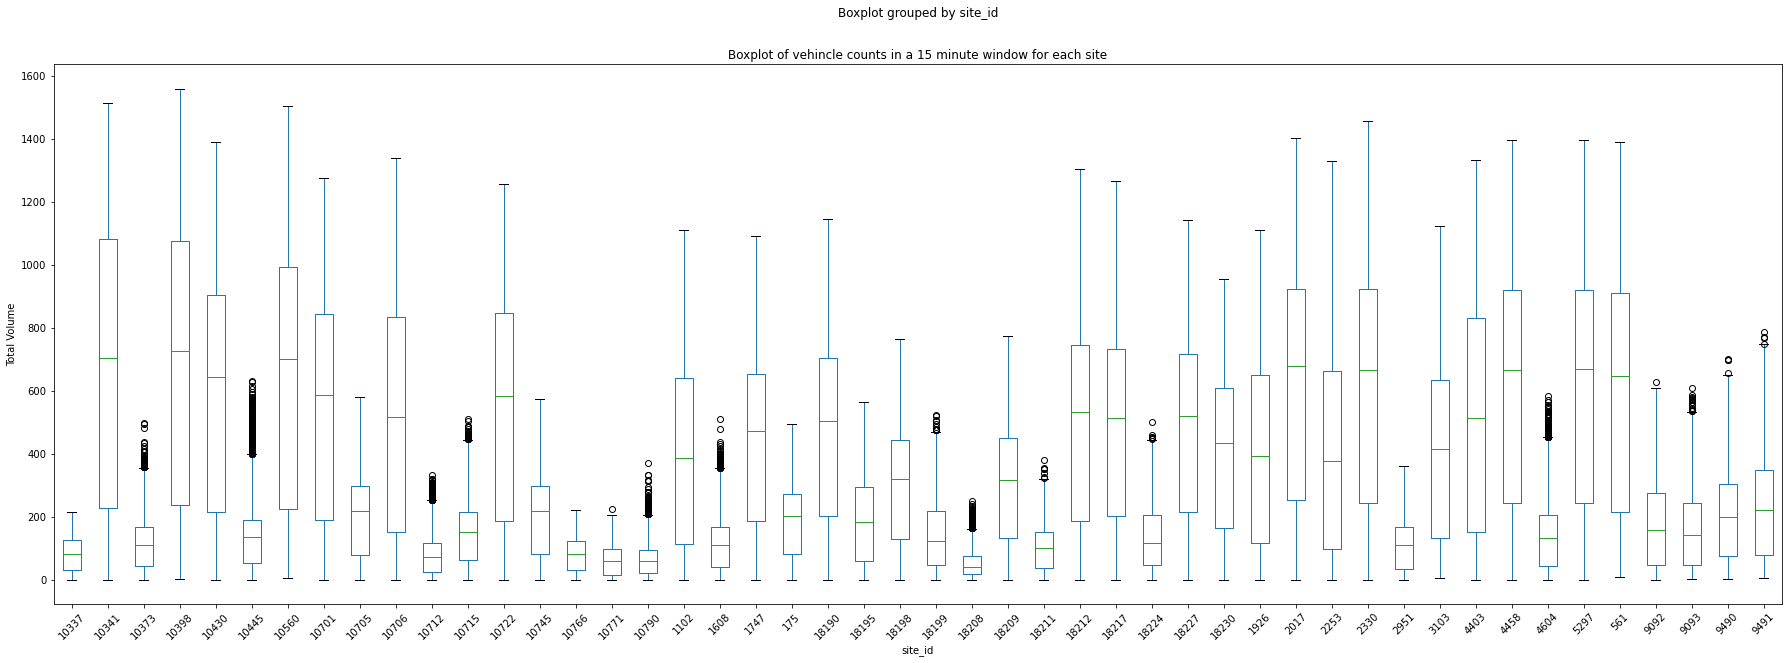

In [12]:
fig, ax = plt.subplots(figsize=(30,10))
clean_train_report_df.boxplot(column='total_volume', by = 'site_id', ax=ax, grid=False, rot=45)
ax.set_title('Boxplot of vehincle counts in a 15 minute window for each site')
ax.set_ylabel('Total Volume')
plt.show()

<AxesSubplot:xlabel='timestamp', ylabel='total_volume_normalised'>

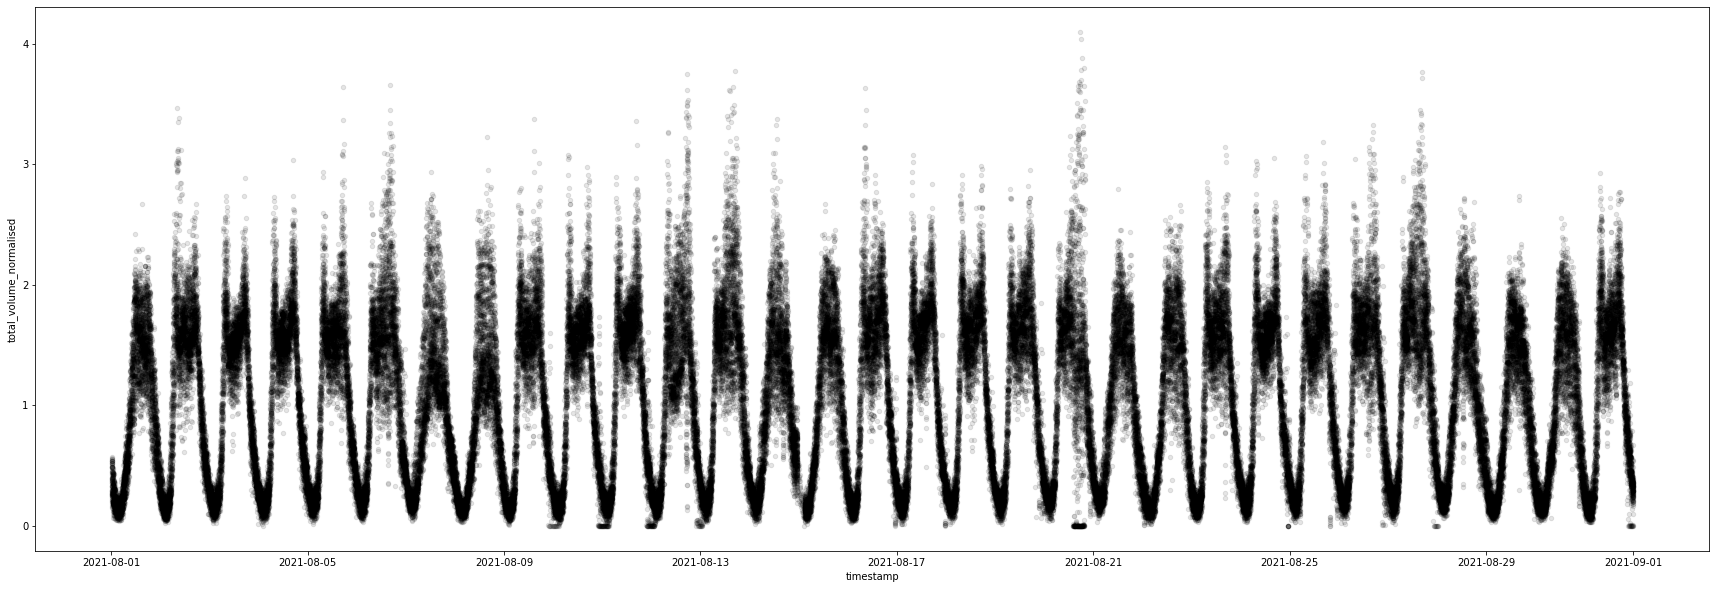

In [13]:
filterd_report = clean_train_report_df.loc[clean_train_report_df['timestamp'].dt.to_period('M')  == '2021-08']
filterd_report.plot('timestamp','total_volume_normalised', figsize = (30,10), kind = 'scatter', alpha=0.1, c='black')

<AxesSubplot:xlabel='timestamp', ylabel='total_volume_normalised'>

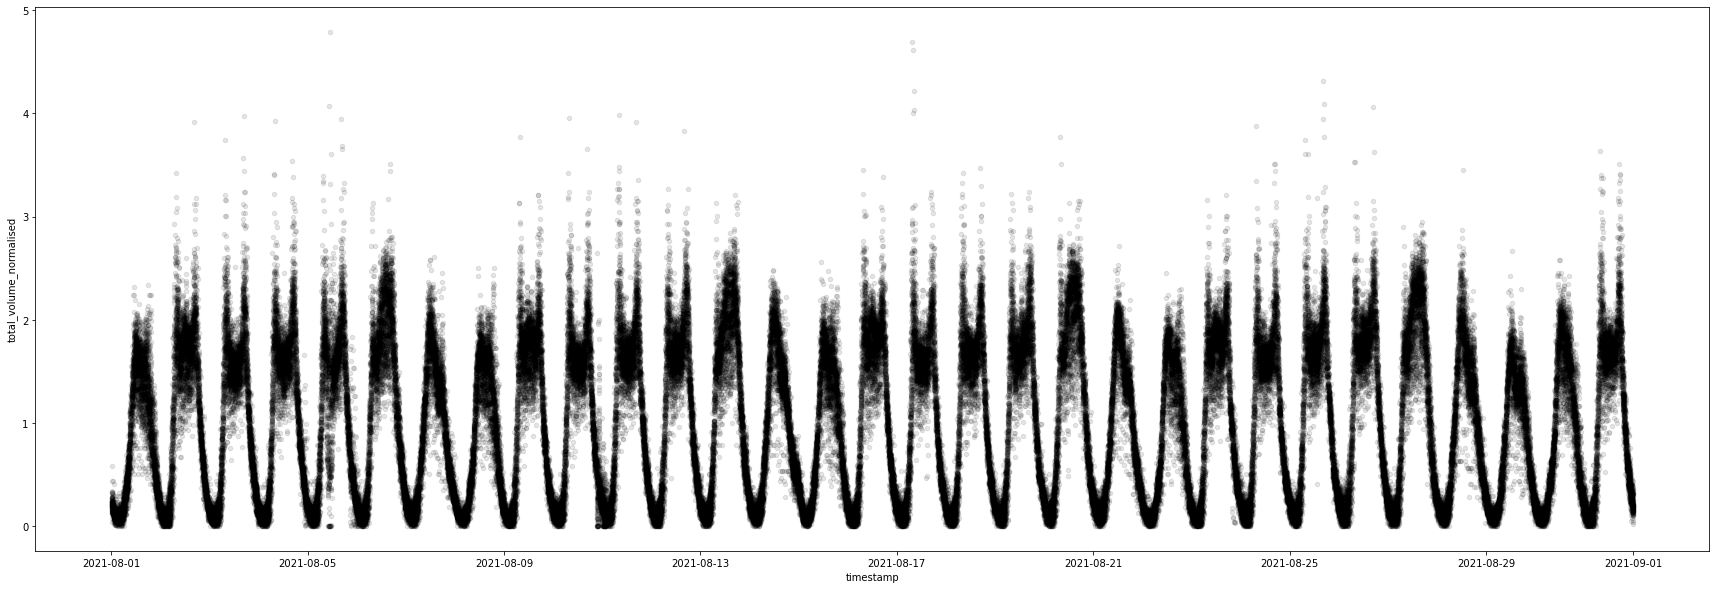

In [14]:
filterd_report = clean_test_report_df.loc[clean_test_report_df['timestamp'].dt.to_period('M')  == '2021-08']
filterd_report.plot('timestamp','total_volume_normalised', figsize = (30,10), kind = 'scatter', alpha=0.1, c='black')

In [15]:
clean_test_report_df

,site_name,site_id,report_date,time_period_ending,time_interval,0-520cm,521-660cm,661-1160cm,1160+cm,avg_mph,total_volume,timestamp,hour,DOW,month,0-520cm_normalised,521-660cm_normalised,661-1160cm_normalised,1160+cm_normalised,total_volume_normalised
3336,M11/6904A,65,2021-07-05T00:00:00,18:14:00,72,386,39,17,84,61,525,2021-07-05 18:14:00,18,0,7,2.098724,3.058174,1.863647,2.508286,2.194041
3337,M11/6904A,65,2021-07-05T00:00:00,18:29:00,73,338,27,12,69,62,446,2021-07-05 18:29:00,18,0,7,1.837743,2.117198,1.315515,2.060378,1.86389
3338,M11/6904A,65,2021-07-05T00:00:00,18:44:00,74,271,16,8,64,63,359,2021-07-05 18:44:00,18,0,7,1.473457,1.254636,0.87701,1.911075,1.500306
3339,M11/6904A,65,2021-07-05T00:00:00,18:59:00,75,236,19,11,46,64,312,2021-07-05 18:59:00,18,0,7,1.283158,1.48988,1.205889,1.373585,1.303888
3340,M11/6904A,65,2021-07-05T00:00:00,19:14:00,76,185,9,8,52,62,254,2021-07-05 19:14:00,19,0,7,1.005865,0.705733,0.87701,1.552749,1.061498
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1819579,M11/6914L,18858,2022-06-15T00:00:00,22:59:00,91,6,1,0,1,60,8,2022-06-15 22:59:00,22,2,6,0.188962,0.237194,0.0,1.614685,0.210895
1819580,M11/6914L,18858,2022-06-15T00:00:00,23:14:00,92,2,0,0,0,56,2,2022-06-15 23:14:00,23,2,6,0.062987,0.0,0.0,0.0,0.052724
1819581,M11/6914L,18858,2022-06-15T00:00:00,23:29:00,93,3,0,0,0,58,3,2022-06-15 23:29:00,23,2,6,0.094481,0.0,0.0,0.0,0.079086
1819582,M11/6914L,18858,2022-06-15T00:00:00,23:44:00,94,7,2,0,0,58,9,2022-06-15 23:44:00,23,2,6,0.220456,0.474389,0.0,0.0,0.237257


### Export the cleaned reports

In [98]:
clean_train_report_df.reset_index(drop=True).to_feather('clean_train_report_df.feather')
clean_test_report_df.reset_index(drop=True).to_feather('clean_test_report_df.feather')

# Normalised Flow Model

In [34]:
clean_test_report_df = pd.read_feather('clean_train_report_df.feather')
clean_train_report_df = pd.read_feather('clean_test_report_df.feather')

In [16]:
import numpy as np
from patsy import dmatrices
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

In [35]:
# Pick cols for model
cols = ['total_volume_normalised', 'hour', 'DOW', 'month']
# Train and test data are made from these
data_train = clean_train_report_df[cols]
data_test = clean_test_report_df[cols]
data_train

,total_volume_normalised,hour,DOW,month
0,2.194041,18,0,7
1,1.863890,18,0,7
2,1.500306,18,0,7
3,1.303888,18,0,7
4,1.061498,19,0,7
...,...,...,...,...
1754648,0.210895,22,2,6
1754649,0.052724,23,2,6
1754650,0.079086,23,2,6
1754651,0.237257,23,2,6


In [31]:
data_train.DOW.unique()

array(['0', '1', '2', '3', '4', '5', '6'], dtype=object)

In [32]:
data_train.hour.unique()

array(['18', '19', '20', '21', '22', '23', '0', '1', '2', '3', '4', '5',
       '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17'],
      dtype=object)

In [36]:
data_test

,total_volume_normalised,hour,DOW,month
0,0.288589,0,1,6
1,0.304924,0,1,6
2,0.179688,0,1,6
3,0.201468,0,1,6
4,0.206913,1,1,6
...,...,...,...,...
1483418,0.029889,17,4,2
1483419,0.037361,17,4,2
1483420,0.034870,17,4,2
1483421,0.034870,17,4,2


In [37]:
y_train, X_train = dmatrices("total_volume_normalised ~ hour*DOW", data_train)

In [38]:
# Make the model matrix and predictions
y_train, X_train = dmatrices("total_volume_normalised ~ hour*DOW", data_train)
# Create model matrix for test data
y_test, X_test = dmatrices("total_volume_normalised ~ hour*DOW", data_test)

model = LinearRegression()
model.fit(X_train,y_train)

# Make predictions on train data
predictions_train = model.predict(X_train)
# Make predictions on test data
predictions_test = model.predict(X_test)

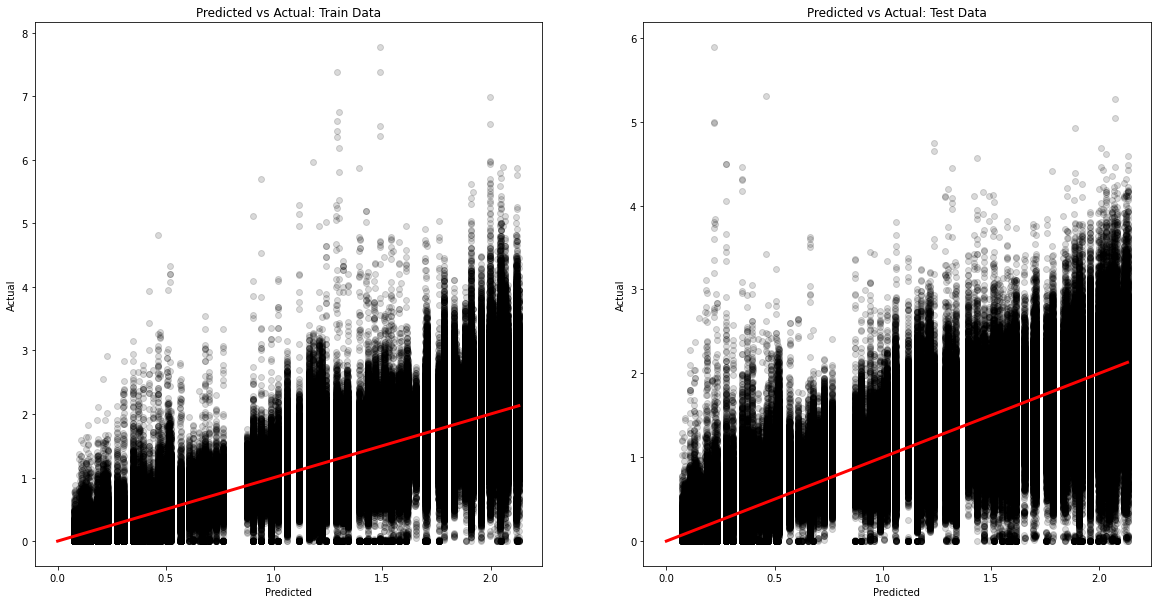

In [49]:
# Plot predictions vs actual
fig, ax = plt.subplots(1,2,figsize=(20,10))

ax[0].scatter(predictions_train, y_train,  alpha = 0.15, c='black')
xmax = max(predictions_train)
ax[0].plot([0,xmax],[0,xmax], lw=3, c='red')
ax[0].set_title('Predicted vs Actual: Train Data')
ax[0].set_ylabel('Actual')
ax[0].set_xlabel('Predicted')

ax[1].scatter(predictions_test, y_test,  alpha = 0.15, c='black')
xmax = max(predictions_test)
ax[1].plot([0,xmax],[0,xmax], lw=3, c='red')
ax[1].set_title('Predicted vs Actual: Test Data')
ax[1].set_ylabel('Actual')
ax[1].set_xlabel('Predicted')

plt.show()

In [41]:
clean_test_report_df.loc[:,'total_volume_normalised_predictions'] = predictions_test

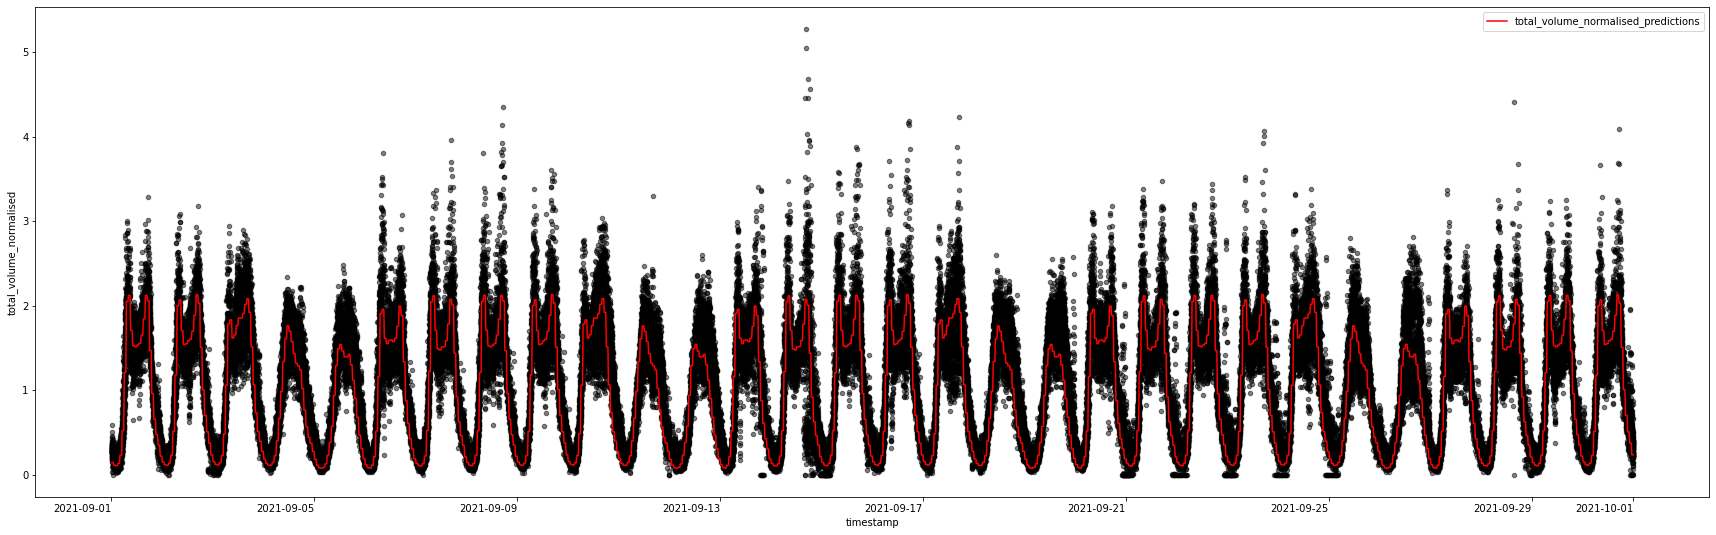

In [42]:
# Focus on particular month so we can actually see the data
filterd_report = clean_test_report_df.loc[clean_test_report_df['timestamp'].dt.to_period('M')  == '2021-09']

fig, ax = plt.subplots(figsize=(20,5))
filterd_report.plot('timestamp','total_volume_normalised_predictions', figsize = (30,10), c='red', kind='line', ax=ax)
filterd_report.plot('timestamp','total_volume_normalised', figsize = (30,10), c='black', kind='scatter', alpha=0.5, ax=ax)
plt.show()

<AxesSubplot:xlabel='timestamp'>

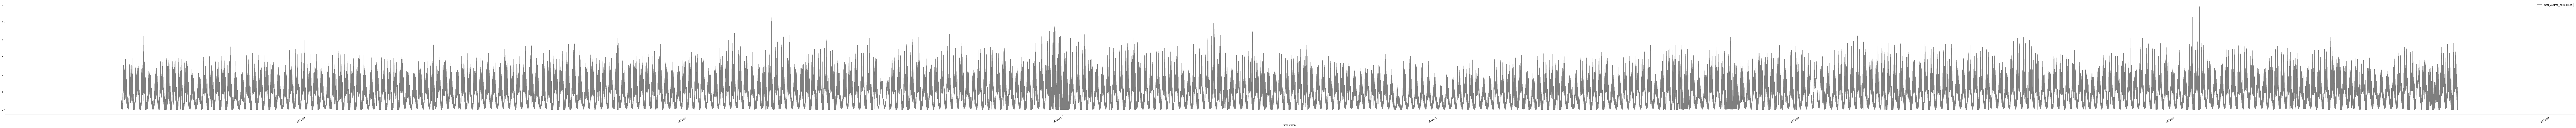

In [55]:
clean_test_report_df.plot('timestamp','total_volume_normalised', figsize = (200,10), c='black', kind='line', alpha=0.5)


In [44]:
def test_report(y_true, y_pred):
    print(f"MSE: {mean_squared_error(y_true, y_pred)}")
    print(f"MAE: {mean_absolute_error(y_true, y_pred)}")
    print(f"R^2: {r2_score(y_true, y_pred)}")
test_report(y_test,predictions_test)

MSE: 0.10094734389245662
MAE: 0.22246200794411608
R^2: 0.761677052210288
